In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from konlpy.tag import Mecab #형태소 분석기
from collections import Counter

import matplotlib.pyplot as plt

### 1. 데이터

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


- train_data[2]의 경우 띄어쓰기가 되어있지 않고 오타가 존재한다.

In [3]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


- test_data[0]의 경우 ㅋ, test_data[1]의 경우 영어

In [4]:
print(train_data.shape, test_data.shape)

(150000, 3) (50000, 3)


### 2. 데이터 로더 구성
- 데이터의 중복 제거
- nan 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어 제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- x_train, y_train, x_test, y_test, word_to_index return

In [5]:
train_data['document'].nunique() # document열만 중복 존재, 3818개는 중복에 해당

146182

In [6]:
test_data['document'].nunique()

49157

In [7]:
print(train_data.isnull().sum()) #document열에 5개의 nan값 존재->제거예정

id          0
document    5
label       0
dtype: int64


In [8]:
print(test_data.isnull().sum()) 

id          0
document    3
label       0
dtype: int64


In [9]:
tokenizer = Mecab() 
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words = 10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)#중복제거
    train_data = train_data.dropna(how='any') #하나라도 na이면, 제거
    test_data.drop_duplicates(subset=['document'],inplace=True)
    test_data = test_data.dropna(how='any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_train = tokenizer.morphs(sentence) #토큰화
        temp_train = [word for word in temp_train if not word in stopwords] #불용어 제거
        X_train.append(temp_train)
        
    X_test = []
    for sentence in test_data['document']:
        temp_test = tokenizer.morphs(sentence)
        temp_test = [word for word in temp_test if not word in stopwords]
        X_test.append(temp_test)
    
    words = np.concatenate(X_train).tolist() #하나의 배열로 합치고 리스트화
    counter = Counter(words) #단어의 빈도 계산
    counter = counter.most_common(9996) #상위 9996개의 단어(4개는 특별한 토큰을 위한 자리)
    vocab = ['','','','']+[key for key,_ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    

enumerate(vocab)
- vocab 리스트의 각 단어와 인덱스를 반환

wordlist_to_indexlist
- wordlist의 각 단어 word
- word가 word_to_index에 있다면 word_to_index[word]값 사용
- word가 word_to_index에 없다면 word_to_index['']값(빈 문자열) 사용

In [10]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [11]:
word_to_index['<PAD>'] = 0
word_to_index['<BOS>'] = 1 # 패딩용 단어
word_to_index['<UNK>'] = 2 # 문장의 시작지점
word_to_index["<UNUSED>"] = 3

In [12]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [13]:
index_to_word

{3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95: '시간',
 96: '지루',
 97: '중',
 98: '재미있'

In [14]:
# 문장 1개를 단어 인덱스 리스트 벡터로 변환해주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3. 모델 구성을 위한 데이터 분석 및 가공
- 데이터 셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

In [15]:
total_data_text = list(X_train)+list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ',np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ',np.std(num_tokens))

for i in range(2,6):
    max_tokens = np.mean(num_tokens) + i * np.std(num_tokens) #최대길이 조정
    maxlen = int(max_tokens)
    print('pad_sequences maxlen : ',maxlen)
    print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다
pad_sequences maxlen :  54
전체 문장의 0.9720946661956905%가 maxlen 설정값 이내에 포함됩니다
pad_sequences maxlen :  67
전체 문장의 0.99755809131817%가 maxlen 설정값 이내에 포함됩니다
pad_sequences maxlen :  80
전체 문장의 0.9999180911133977%가 maxlen 설정값 이내에 포함됩니다


In [16]:
maxlen = 54

- maxlen = 54로 설정

In [17]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value = word_to_index['<PAD>'],
                                                       padding = 'pre',
                                                       maxlen = maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value = word_to_index['<PAD>'],
                                                       padding = 'pre',
                                                       maxlen = maxlen)

In [18]:
print(X_train.shape,X_test.shape)

(146182, 54) (49157, 54)


### 4. 모델 구성 및 validation set 구성
- 모델 3가지 이상 다양하게 구성하여 실험

In [19]:
print(len(X_train)*0.2)
# 약 train셋의 20%를 검증 데이터로 사용

29236.4


In [20]:
# 데이터 셋 분리
x_val = X_train[:30000]
y_val = y_train[:30000]

partial_x_train = X_train[30000:]
partial_y_train = y_train[30000:]

4-1. RNN model

In [21]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim,input_shape=(None,)))
lstm.add(tf.keras.layers.LSTM(8))
lstm.add(tf.keras.layers.Dense(8, activation='relu'))
lstm.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 3488      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


4-2. CNN

In [22]:
cnn = tf.keras.Sequential()
cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(tf.keras.layers.MaxPooling1D(5))
cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(tf.keras.layers.GlobalMaxPooling1D())
cnn.add(tf.keras.layers.Dense(8, activation='relu'))
cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

4-3.maxpool

In [23]:
maxpool = tf.keras.Sequential()
maxpool.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
maxpool.add(tf.keras.layers.GlobalMaxPooling1D())
maxpool.add(tf.keras.layers.Dense(8, activation='relu'))
maxpool.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

maxpool.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


### 5. 모델 훈련 개시

In [24]:
epochs = 20

lstm.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics = ['accuracy'])

historyl = lstm.fit(partial_x_train,partial_y_train,
                epochs=epochs,
                batch_size=512,
                validation_data=(x_val, y_val),
                verbose=1)

Epoch 1/20
227/227 [==============================] - 5s 8ms/step - loss: 0.4578 - accuracy: 0.7974 - val_loss: 0.3543 - val_accuracy: 0.8465
Epoch 2/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3277 - accuracy: 0.8630 - val_loss: 0.3407 - val_accuracy: 0.8517
Epoch 3/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3011 - accuracy: 0.8739 - val_loss: 0.3402 - val_accuracy: 0.8540
Epoch 4/20
227/227 [==============================] - 1s 6ms/step - loss: 0.2809 - accuracy: 0.8846 - val_loss: 0.3418 - val_accuracy: 0.8542
Epoch 5/20
227/227 [==============================] - 1s 6ms/step - loss: 0.2626 - accuracy: 0.8934 - val_loss: 0.3464 - val_accuracy: 0.8544
Epoch 6/20
227/227 [==============================] - 1s 6ms/step - loss: 0.2438 - accuracy: 0.9028 - val_loss: 0.3535 - val_accuracy: 0.8528
Epoch 7/20
227/227 [==============================] - 1s 6ms/step - loss: 0.2258 - accuracy: 0.9113 - val_loss: 0.3675 - val_accuracy: 0.8503
Epoch 

In [25]:
cnn.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics = ['accuracy'])

history2 = cnn.fit(partial_x_train,partial_y_train,
                epochs=epochs,
                batch_size=512,
                validation_data=(x_val, y_val),
                verbose=1)

Epoch 1/20
227/227 [==============================] - 3s 7ms/step - loss: 0.5285 - accuracy: 0.7256 - val_loss: 0.4319 - val_accuracy: 0.7885
Epoch 2/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3941 - accuracy: 0.8161 - val_loss: 0.4196 - val_accuracy: 0.7957
Epoch 3/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3500 - accuracy: 0.8395 - val_loss: 0.4231 - val_accuracy: 0.7966
Epoch 4/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3036 - accuracy: 0.8651 - val_loss: 0.4398 - val_accuracy: 0.7966
Epoch 5/20
227/227 [==============================] - 1s 6ms/step - loss: 0.2501 - accuracy: 0.8911 - val_loss: 0.4862 - val_accuracy: 0.7909
Epoch 6/20
227/227 [==============================] - 1s 6ms/step - loss: 0.2005 - accuracy: 0.9133 - val_loss: 0.5340 - val_accuracy: 0.7847
Epoch 7/20
227/227 [==============================] - 1s 6ms/step - loss: 0.1626 - accuracy: 0.9294 - val_loss: 0.6016 - val_accuracy: 0.7811
Epoch 

In [26]:
maxpool.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics = ['accuracy'])

history3 = maxpool.fit(partial_x_train,partial_y_train,
                epochs=epochs,
                batch_size=512,
                validation_data=(x_val, y_val),
                verbose=1)

Epoch 1/20
227/227 [==============================] - 2s 5ms/step - loss: 0.4885 - accuracy: 0.7951 - val_loss: 0.3537 - val_accuracy: 0.8441
Epoch 2/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3215 - accuracy: 0.8634 - val_loss: 0.3356 - val_accuracy: 0.8524
Epoch 3/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2771 - accuracy: 0.8864 - val_loss: 0.3380 - val_accuracy: 0.8550
Epoch 4/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2427 - accuracy: 0.9026 - val_loss: 0.3486 - val_accuracy: 0.8565
Epoch 5/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2107 - accuracy: 0.9180 - val_loss: 0.3655 - val_accuracy: 0.8534
Epoch 6/20
227/227 [==============================] - 1s 4ms/step - loss: 0.1793 - accuracy: 0.9343 - val_loss: 0.3897 - val_accuracy: 0.8494
Epoch 7/20
227/227 [==============================] - 1s 4ms/step - loss: 0.1485 - accuracy: 0.9485 - val_loss: 0.4150 - val_accuracy: 0.8480
Epoch 

In [27]:
# 평가

results = lstm.evaluate(X_test, y_test, verbose=2)
print('LSTM : ', results)
results = cnn.evaluate(X_test, y_test, verbose=2)
print('CNN : ', results)
results = maxpool.evaluate(X_test, y_test, verbose=2)
print('Maxpool : ', results)

1537/1537 - 3s - loss: 0.6234 - accuracy: 0.8335
LSTM :  [0.6234163641929626, 0.8335130214691162]
1537/1537 - 3s - loss: 1.4291 - accuracy: 0.7629
CNN :  [1.4290879964828491, 0.7628821730613708]
1537/1537 - 2s - loss: 0.8458 - accuracy: 0.8267
Maxpool :  [0.8458050489425659, 0.8266777992248535]


In [28]:
#history 저장
historyl_dict = historyl.history
history2_dict = history2.history
history3_dict = history3.history

### 6. Loss, Accuracy 그래프 시각화

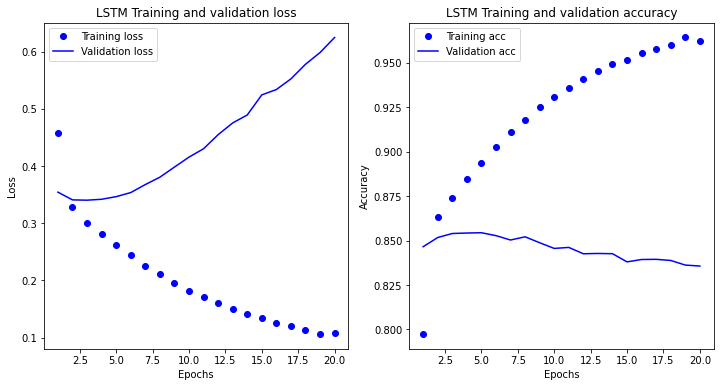

In [29]:
acc = historyl_dict['accuracy']
val_acc = historyl_dict['val_accuracy']
loss = historyl_dict['loss']
val_loss = historyl_dict['val_loss']

epochs = range(1,len(acc)+1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('LSTM Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

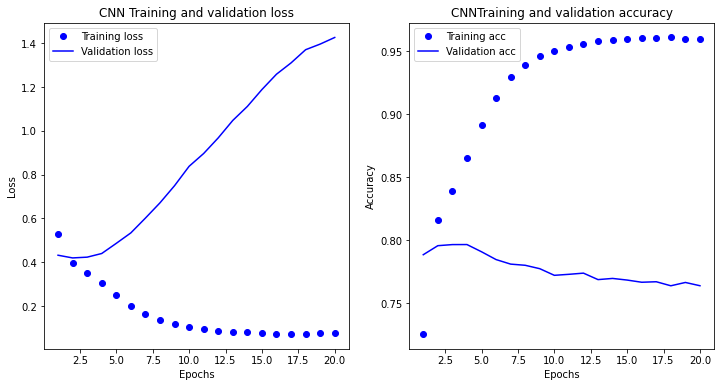

In [30]:
acc = history2_dict['accuracy']
val_acc = history2_dict['val_accuracy']
loss = history2_dict['loss']
val_loss = history2_dict['val_loss']

epochs = range(1,len(acc)+1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('CNNTraining and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

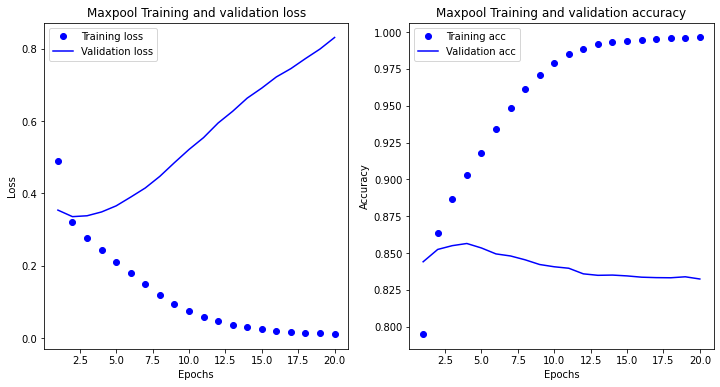

In [31]:
acc = history3_dict['accuracy']
val_acc = history3_dict['val_accuracy']
loss = history3_dict['loss']
val_loss = history3_dict['val_loss']

epochs = range(1,len(acc)+1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Maxpool Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Maxpool Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 3개의 모델 모두 훈련을 할 수록 val_loss값이 늘어나고 val_accuracy는 감소한다.

### 7. 학습된 Embedding 레이어 분석

In [32]:
embedding_layer = lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 100)


In [33]:
import os

from gensim.models.keyedvectors import Word2VecKeyedVectors
# 학습한 embedding 파라미터 파일에 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_project.txt'

f = open(word2vec_file_path,'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = lstm.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i],' '.join(map(str,list(vectors[i,:])))))
f.close()

In [34]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 0.13281685, -0.112754  , -0.14327972,  0.05852357, -0.16460718,
        0.02968135, -0.12599954, -0.0081989 ,  0.07305922,  0.04913638,
        0.07044686, -0.12656325, -0.05981506, -0.06711863, -0.02863572,
        0.14287508, -0.01546755,  0.1939709 , -0.05989785,  0.15648988,
       -0.0979414 ,  0.08328417, -0.0462534 ,  0.07160473, -0.06936952,
        0.07589762, -0.12716082, -0.058134  , -0.10174862, -0.05750353,
        0.11517724, -0.12522547,  0.15158525, -0.15825774, -0.01468216,
       -0.11487768,  0.07061353, -0.03058912,  0.03904375, -0.09113713,
       -0.04296861,  0.08062819,  0.11363484, -0.00339797, -0.05083222,
       -0.03905886,  0.10573821,  0.10257861,  0.06894474, -0.11342028,
        0.06556898,  0.12339891, -0.13551392, -0.00812024, -0.16020313,
       -0.06627438,  0.05236175,  0.05768862, -0.11487824, -0.0662776 ,
       -0.02981076,  0.05717348,  0.13024361,  0.10852966,  0.07760567,
        0.09276222,  0.06168615,  0.00857869, -0.11534085,  0.06

In [35]:
word_vectors.similar_by_word('사랑')

[('걸작', 0.863493025302887),
 ('시네마', 0.8587826490402222),
 ('릿', 0.8564431071281433),
 ('명화', 0.8464125990867615),
 ('대해', 0.8440277576446533),
 ('감탄', 0.8410490155220032),
 ('달콤', 0.838191032409668),
 ('다가왔', 0.8352761268615723),
 ('끝장', 0.8317734003067017),
 ('자유', 0.8303540349006653)]

- 학습이 잘 안된 것 같다...

### 8.한국어 Word2Vec 임베딩 활용하여 성능 개선
- 한국어 word2vec은 /data 폴더 안에 있는 word2vec_ko.model 활용
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요.

In [36]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# ko.model pre-train해보기

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv
vector.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

- 학습이 잘되어있는 것 같음

In [37]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4, vocab_size):
    if index_to_word[i] in vector:
        embedding_matrix[i] = vector[index_to_word[i]]

In [38]:
from tensorflow.keras.initializers import Constant

#모델1
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                     word_vector_dim, 
                                     embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                     input_length=54, 
                                     trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(10))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 54, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 1,004,561
Trainable params: 1,004,561
Non-trainable params: 0
_________________________________________________________________


In [39]:
#모델2
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 54, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 16)            11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [40]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20

History1 = model.fit(partial_x_train,partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

History2= model2.fit(partial_x_train,partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 3s 9ms/step - loss: 0.5618 - accuracy: 0.7060 - val_loss: 0.4501 - val_accuracy: 0.7947
Epoch 2/20
227/227 [==============================] - 2s 7ms/step - loss: 0.4091 - accuracy: 0.8181 - val_loss: 0.3915 - val_accuracy: 0.8280
Epoch 3/20
227/227 [==============================] - 1s 7ms/step - loss: 0.3585 - accuracy: 0.8453 - val_loss: 0.3702 - val_accuracy: 0.8390
Epoch 4/20
227/227 [==============================] - 1s 7ms/step - loss: 0.3301 - accuracy: 0.8613 - val_loss: 0.3656 - val_accuracy: 0.8424
Epoch 5/20
227/227 [==============================] - 1s 7ms/step - loss: 0.3119 - accuracy: 0.8700 - val_loss: 0.3595 - val_accuracy: 0.8461
Epoch 6/20
227/227 [==============================] - 1s 6ms/step - loss: 0.2974 - accuracy: 0.8776 - val_loss: 0.3561 - val_accuracy: 0.8493
Epoch 7/20
227/227 [==============================] - 2s 7ms/step - loss: 0.2858 - accuracy: 0.8833 - val_loss: 0.3654 - val_accuracy: 0.8455
Epoch 

In [41]:
result1 = model.evaluate(X_test,  y_test, verbose=2)
result2 = model2.evaluate(X_test,  y_test, verbose=2)

print('word2vec & LSTM : ',result1)
print('word2vec & cnn : ',result2)

1537/1537 - 3s - loss: 0.4227 - accuracy: 0.8420
1537/1537 - 3s - loss: 0.6060 - accuracy: 0.7720
word2vec & LSTM :  [0.42268502712249756, 0.8419756889343262]
word2vec & cnn :  [0.6059530973434448, 0.772016167640686]


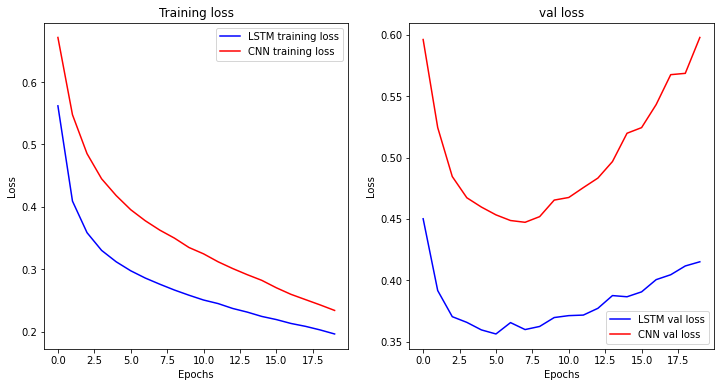

In [42]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(History1.history['loss'],'b', label='LSTM training loss')
plt.plot(History2.history['loss'],'r', label = 'CNN training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(History1.history['val_loss'],'b', label='LSTM val loss')
plt.plot(History2.history['val_loss'],'r', label = 'CNN val loss')
plt.title('val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

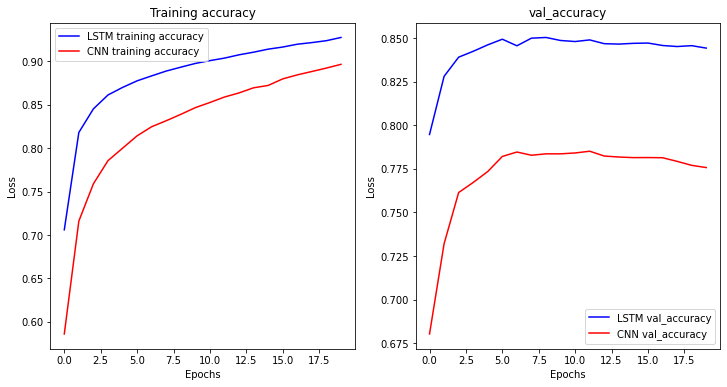

In [43]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(History1.history['accuracy'],'b', label='LSTM training accuracy')
plt.plot(History2.history['accuracy'],'r', label = 'CNN training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(History1.history['val_accuracy'],'b', label='LSTM val_accuracy')
plt.plot(History2.history['val_accuracy'],'r', label = 'CNN val_accuracy')
plt.title('val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### 회고
- LSTM layer을 넣은 모델의 성능이 최종적으로 가장 좋았다.
- 시간적 이유로 성능이 84%까지만 올린 점이 아쉽고 추후 시간에 더 성능 향상 방안을 시도해 볼 예정이다.
- 과적합의 문제가 있는 것으로 보아? 이를 해결하는 방법을 써보면 좋을 것 같다.
- 영어문장만 있는 document를 처리하지 못한 점이 아쉽다.